# Figure 1: Overview of DendroSplit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from dendrosplit import split,merge,utils
from dendrosplit_pipeline import *
%matplotlib inline

In [2]:
dataset = 'Biase'
X = np.loadtxt('../data/%s/%s_expr.txt'%(dataset,dataset)).T
Y = np.loadtxt('../data/%s/%s_labels.txt'%(dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
genes = np.loadtxt('../data/%s/%s_features.txt'%(dataset,dataset),dtype=str)
X,genes = split.filter_genes(X,genes,0) 

Kept 23895 features for having > 0 counts across all cells


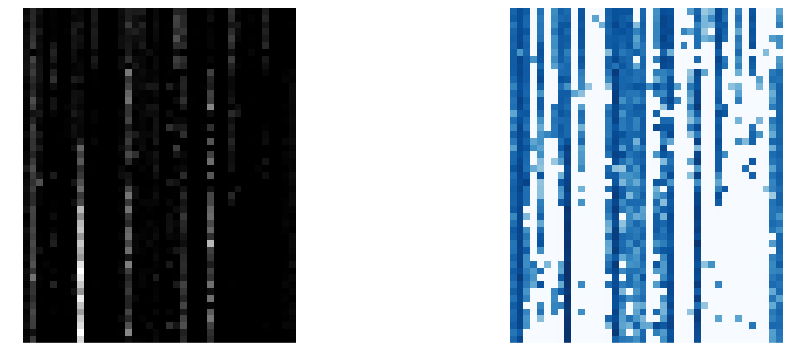

In [3]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(X[:,:40],cmap='gray',interpolation='none')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.log(1+X[:,:40]),interpolation='none',cmap='Blues')
_ = plt.axis('off')

Distance matrix computed in 1.643 s.


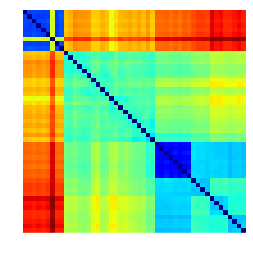

In [4]:
from sklearn.metrics.pairwise import pairwise_distances
D = generate_log_corr_D(X)
plt.imshow(D,interpolation='none')
_ = plt.axis('off')

/home/jessez/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


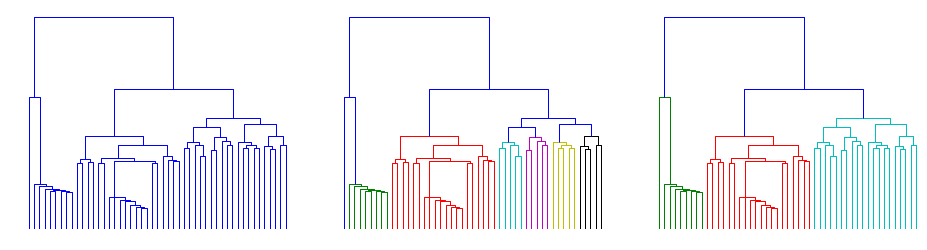

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
Ds = squareform(D)
Z = linkage(Ds,method='complete')

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
_ = dendrogram(Z,color_threshold=0)
plt.axis('off')

plt.subplot(1,3,2)
_ = dendrogram(Z,color_threshold=0.32)
plt.axis('off')

plt.subplot(1,3,3)
_ = dendrogram(Z,color_threshold=0.45)
_ = plt.axis('off')

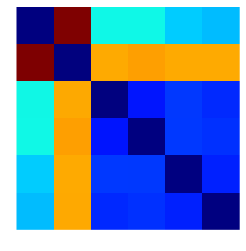

In [6]:
import itertools
labels = fcluster(Z,.32,criterion='distance')
labels[labels == 2] = 1
Nc = len(np.unique(labels))
cache = {}
Dc = np.zeros((Nc,Nc))
# Compute distances for all clusters                                                                                
for i,j in itertools.combinations(range(Nc),2):
    cache,Dc[i,j] = merge.cdist_log_Welchs(X,D,i,j,split.str_labels_to_ints(labels),cache)
    Dc[j,i] = Dc[i,j]
    
plt.imshow(Dc,interpolation='none')
plt.axis('off')

In [7]:
# Merge cluster labels
ym,mhistory = merge.dendromerge((D,X),labels,score_threshold=20,preprocessing='precomputed',
                                verbose=True,outlier_threshold_percentile=100)

0 of 49 samples are singletons
Singletons assigned (0.002 s)
Dc generated (2.341 s)
Before the merge: 6 clusters
Merging labels 2 (N = 5) and 3 (N = 5) with distance 6.43
Before the merge: 5 clusters
Merging labels 2 (N = 5) and 3 (N = 5) with distance 6.88
Before the merge: 4 clusters
Merging labels 2 (N = 10) and 3 (N = 10) with distance 12.91
Merging clusters took 4.388 s


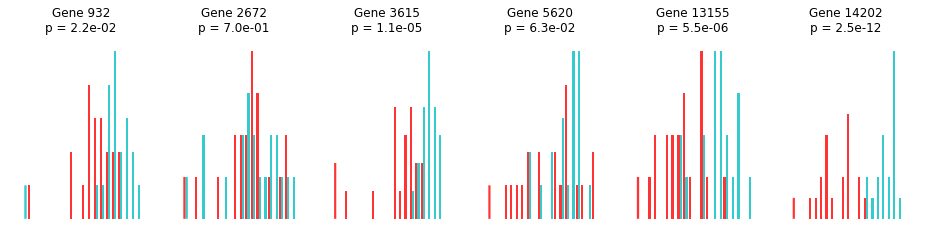

In [8]:
# valid split

from scipy.stats import ttest_ind
Xlog = np.log(1+X)
t,p = ttest_ind(Xlog[Y == 'two_cell'],Xlog[Y == 'four_cell'])
p[np.isnan(p)] = 0.5

# Entries where X is nonzero for all cells
plt.figure(figsize=(16,3))
inds = np.where(np.sum(X == 0,0) == 0)[0]
# for j,i in enumerate(np.sort(np.random.choice(inds,5,replace=False))):
for j,i in enumerate([932, 2672, 3615, 5620, 13155, 14202]):
    plt.subplot(1,6,j+1)
    v1 = Xlog[Y == 'two_cell',i]
    v2 = Xlog[Y == 'four_cell',i]
    bins = np.histogram(np.hstack((v1,v2)), bins=20)[1]
    data = np.vstack([v1, v2]).T
    plt.hist(data,bins,label=['two_cell','four_cell'],
             alpha=0.8,color=['r','c'],edgecolor='none')
    plt.title('Gene %s\np = %.1e\n'%(i,p[i]))
    plt.axis('off')

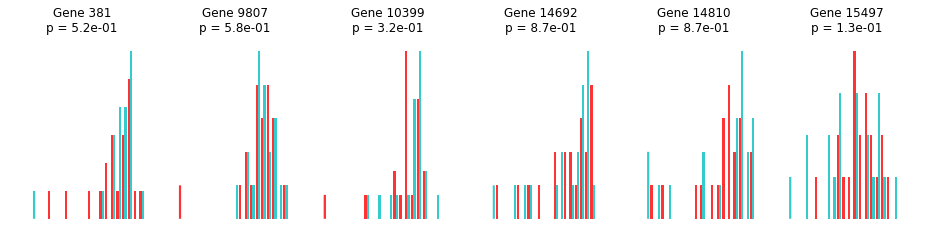

In [9]:
# poor split

plt.figure(figsize=(16,3))
inds = np.where(np.sum(X == 0,0) == 0)[0]
for j,i in enumerate([381, 9807, 10399, 14692, 14810, 15497]):
    plt.subplot(1,6,j+1)
    v1 = Xlog[Y == 'two_cell',i]
    v2 = Xlog[Y == 'four_cell',i]
    bins = np.histogram(np.hstack((v1,v2)), bins=20)[1]
    data = np.vstack([v1, v2]).T
    plt.hist(data,bins,label=['two_cell','four_cell'],
             alpha=0.8,color=['r','c'],edgecolor='none')
    plt.title('Gene %s\np = %.1e\n'%(i,p[i]))
    plt.axis('off')